<a href="https://colab.research.google.com/github/ericmuckley/code/blob/master/refrigerant_channel_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement learning of neutron images

This notebook is designed for analysis of neutron data of refrigerant
flowing through a microfluidic channel.


Created on Thu Feb 13 10:33:13 2020  
author: ericmuckley@gmail.com

## Prepare data

### Import libraries

In [0]:
import json
import math
import itertools
import numpy as np
from glob import glob
from time import time
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
from google.colab import files

#from google.colab import drive
#drive.mount('/content/gdrive')

### Import images from Github

In [2]:
# clone the entire github repository where the data file is located
%cd /content/
!rm -rf cloned-data
!git clone -l -s git://github.com/ericmuckley/datasets.git cloned-data
# navigate to the repo
%cd cloned-data/refrigerant_images/

# set path of folder which contains image files
folder_path = "/content/cloned-data/refrigerant_images/*.*"
all_images = glob(folder_path)
print('\n------------------------\nFound {} files:'.format(len(all_images)))
for img in all_images:
    print(img.split('/')[-1])

/content
Cloning into 'cloned-data'...
remote: Enumerating objects: 245, done.
remote: Total 245 (delta 0), reused 0 (delta 0), pack-reused 245
Receiving objects: 100% (245/245), 246.86 MiB | 29.27 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Checking out files: 100% (77/77), done.
/content/cloned-data/refrigerant_images

------------------------
Found 18 files:
75lbh000080.tif
75lbh000020.tif
25lbhA0020.tif
75lbh000040.tif
75lbh000010.tif
25lbhA0070.tif
75lbh000090.tif
75lbh000060.tif
75lbh000050.tif
25lbhA0050.tif
25lbhA0010.tif
75lbh000030.tif
25lbhA0060.tif
75lbh000070.tif
emptytestsectA0.tif
25lbhA0030.tif
75lbh000100.tif
25lbhA0040.tif


### Define some functions to use later

In [0]:
# change matplotlib settings to make plots look nicer
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['ytick.major.width'] = 3


def plot_setup(labels=['X', 'Y'], fsize=18, setlimits=False,
               limits=[0,1,0,1], title='', size=None,
               legend=False, save=False, filename='plot.jpg'):
    """Creates a custom plot configuration to make graphs look nice.
    This can be called with matplotlib for setting axes labels,
    titles, axes ranges, and the font size of plot labels.
    This should be called between plt.plot() and plt.show() commands."""
    plt.xlabel(str(labels[0]), fontsize=fsize)
    plt.ylabel(str(labels[1]), fontsize=fsize)
    plt.title(title, fontsize=fsize)
    fig = plt.gcf()
    if size:
        fig.set_size_inches(size[0], size[1])
    else:
        fig.set_size_inches(10, 10)
    if legend:
        plt.legend(fontsize=fsize-4)
    if setlimits:
        plt.xlim((limits[0], limits[1]))
        plt.ylim((limits[2], limits[3]))
    if save:
        fig.savefig(filename, dpi=120, bbox_inches='tight')
        plt.tight_layout()


def scale_image(image, scaling_factor=2):
    """Scale a 2D image using a scaling factor."""
    from skimage.transform import resize
    # get number of pixels in each dimension
    x_pixels = np.shape(image)[1]
    y_pixels = np.shape(image)[0]
    scaled_image  = resize(
        image, (scaling_factor*y_pixels, scaling_factor*x_pixels))
    return scaled_image


def plot_channel_image(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()


def get_bubble_profile(rad=10):
    """Get the 3D surface profile of a bubble using its radius,
    based on the equation of a sphere (x^2 + y^2 + z^2 = r^2)."""
    # create 2D x-y grid
    xgrid, ygrid = np.meshgrid(np.linspace(-rad, rad, num=1+2*rad),
                               np.linspace(-rad, rad, num=1+2*rad))
    # calculate value of 3D bubble surface based on equation of sphere
    z = np.sqrt(np.square(rad)-np.square(xgrid)-np.square(ygrid))
    # replace nan values with zeros
    return np.nan_to_num(z)

    
def add_bubble_to_grid(grid, bub_profile, rad=10, cent=(0,0)):
    """Add profile of the bubble to a simulated grid of possible bubbles."""
    # get limits of pixel coordinates
    xmax = len(grid[0])-1
    ymax = len(grid)-1
    # get slice indices of image which will be populated by bubble
    x1, x2 = cent[0]-rad, cent[0]+rad+1
    y1, y2 = cent[1]-rad, cent[1]+rad+1
    # trim bubble and image indices if bubble extends outside image range
    if x1 < 0:
        bub_profile = bub_profile[:, -x1:]
        x1 = 0
    if x2 > xmax:
        bub_profile = bub_profile[:, :-(x2-xmax)]
        x2 = xmax
    if y1 < 0:
        bub_profile = bub_profile[-y1:]
        y1 = 0
    if y2 > ymax:
        bub_profile = bub_profile[:-(y2-ymax)]
        y2 = ymax
    # add new bubble profile to existing grid
    grid_new = np.zeros_like(grid)
    grid_new[y1:y2, x1:x2] += bub_profile
    return grid_new

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
            np.float64)):
            return float(obj)
        elif isinstance(obj,(np.ndarray,)): #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

### Trim empty space out of images

The empty space around each channel is removed, and the inner channel
region is bordered by red lines in the plot below. Finally, the
inner channel region is isolated from the rest of the image to isolate
the area of interest. The void faction of each region of interest is
calculated so that  blue=0 and red=1.

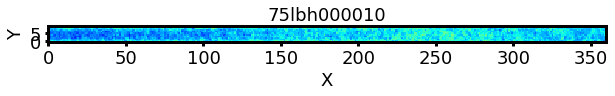

Trimmed image pixel shape: (10, 360)


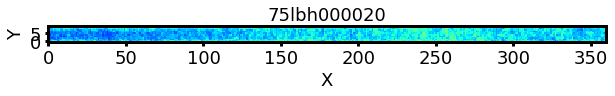

Trimmed image pixel shape: (10, 360)


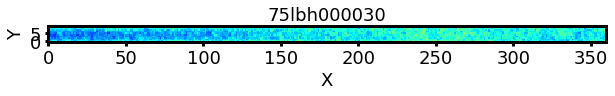

Trimmed image pixel shape: (10, 360)


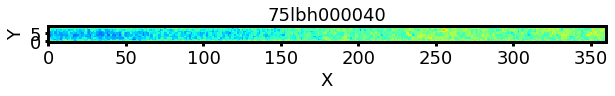

Trimmed image pixel shape: (10, 360)


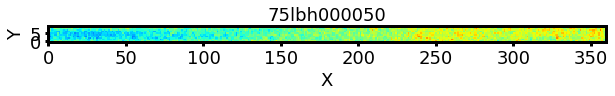

Trimmed image pixel shape: (10, 360)


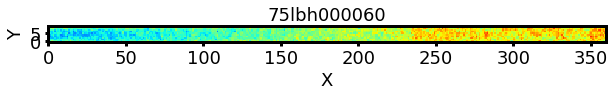

Trimmed image pixel shape: (10, 360)


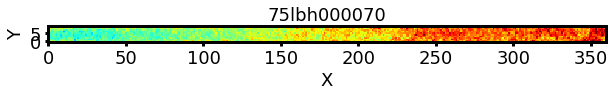

Trimmed image pixel shape: (10, 360)


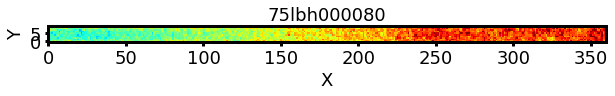

Trimmed image pixel shape: (10, 360)


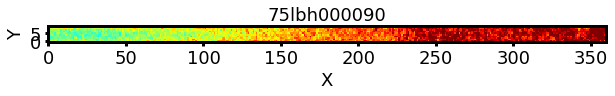

Trimmed image pixel shape: (10, 360)


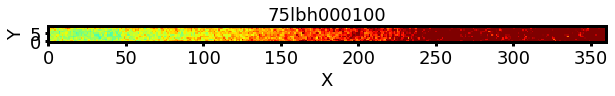

Trimmed image pixel shape: (10, 360)


In [4]:
# set vertical pixel limits that we want to select to remove aluminum area
rlims25 = [245, 280]
rlims75 = [225, 270]

# This section commented out because we are only looking at 75 lb flowrate
# images for now
# get list of all images and their titles
#img_names = [i for i in all_images if 'empty' not in i]
#labels = [i.split('/')[-1].split('.tif')[0] for i in img_names]
# get reference image as a 2D numpy array
#ref_img_name = [i for i in all_images if 'empty' in i][0]
#ref_img = plt.imread(ref_img_name)[:, :, 0].T[rlims75[0]:rlims75[1]]

# create dictionary to hold all results
d = {}

# loop over each non-reference image
# look at only 75 lb flow rate images for now
img_names = sorted([i for i in all_images if '75' in i])
labels = [i.split('/')[-1].split('.tif')[0] for i in img_names]
for i, img in enumerate(img_names):
    
    # get flowrate and temperature from image names
    flowrate = int(labels[i].split('lb')[0])
    if flowrate == 25:
        img = plt.imread(img)[:, :, 0].T[rlims25[0]:rlims25[1]]
        temp = int(labels[i].split('00')[-1])
        xlims = [68, 428]
        ylims= [15, 25]
    if flowrate == 75:
        img = plt.imread(img)[:, :, 0].T[rlims75[0]:rlims75[1]]
        temp = int(labels[i].split('000')[-1])
        xlims = [97, 457]
        ylims = [20, 30]
        
    # cut image to only include channel interior
    channel_img = img[ylims[0]:ylims[1], xlims[0]:xlims[1]]

    # save results into dictionary
    d[labels[i]] = {
            'flowrate': flowrate,
            'temp': temp,
            'img_full': img,
            'img_channel': channel_img,
            'par_profile_full': np.mean(img, axis=0),
            'perp_profile_full': np.mean(img, axis=1),
            'par_profile_channel': np.mean(channel_img, axis=0),
            'perp_profile_channel': np.mean(channel_img, axis=1),
            'channel_min': np.min(channel_img),
            'channel_max': np.max(channel_img),
            'channel_mean': np.mean(channel_img),
            'channel_std': np.std(channel_img),
            'void_frac_img': channel_img/255} 

    # plot results
    show_full_image = False
    show_channel_image = True
    if show_full_image:
        # plot horizontal bounding lines
        plt.axvline(x=xlims[0], color='r', lw=1)
        plt.axvline(x=xlims[1], color='r', lw=1)
        # plot vertical bounding lines
        plt.axhline(y=ylims[0], color='r', lw=1)
        plt.axhline(y=ylims[1], color='r', lw=1)
        # find pixel number which is in the vertical center
        center_vert_pix = len(img) // 2
        #plt.axhline(y=center_vert_pix, color='r', lw=1)
        plt.imshow(img, origin='lower', vmin=0, vmax=255)
        plt.title(labels[i])
        plot_setup(title=labels[i])
        plt.show()
    if show_channel_image:
        plt.imshow(d[labels[i]]['void_frac_img'], origin='lower',
                   vmin=0, vmax=1, cmap='jet')
        plot_setup(title=labels[i])
        plt.show()
        print('Trimmed image pixel shape: {}'.format(np.shape(channel_img)))
    print('==============================================================')                                                                    

## Prepare machine learning problem

### Define physical dimensions and constraints

First we determine the possible frequencies of occurence of each type of
bubble inside a given area. We take all combinations of possible bubbles, and
based on their diameters, remove possibilities which are not physically
relevant (i.e. multiple large bubbles together which will not fit inside a
given area.) The physical relevance is based on maximum and minimum
possible bubble diameters, number of distinct bubble sizes we want to search
for, and the physical channel dimensions.

In [0]:
# define channel dimensions (width, height, depth) in μm
channel = {'w': 22000, 'h': 250, 'd': 750}

# define bubble radius limits and min buffer distance between bubbles in μm
bubble = {'min_rad': 1, 'max_rad': 60, 'buffer': 1}

promising parameters:

channel = {'w': 22000, 'h': 250, 'd': 750}

bubble = {'min_rad': 1, 'max_rad': 60, 'buffer': 1}

img = scale_image(img, scaling_factor=int(0.1*channel['w']/len(img[0])))

plot_channel_image(img, title='Rescaled image', vmin=0, vmax=1)

max_bubbles = 1000000


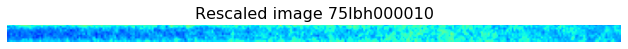

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in sqrt


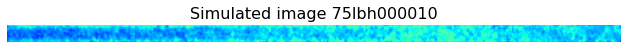

total bubbles: 39423, runtime (min): 5.6, error (%): 4.1
--------------------------------------------------------------



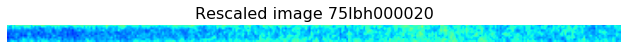

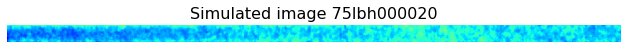

total bubbles: 38490, runtime (min): 11.1, error (%): 4.02
--------------------------------------------------------------



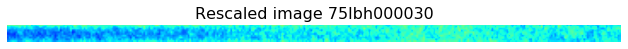

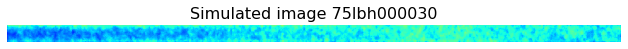

total bubbles: 38415, runtime (min): 16.7, error (%): 4.0
--------------------------------------------------------------



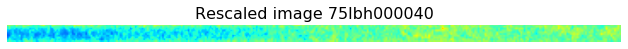

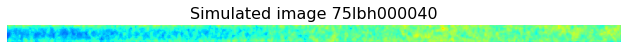

total bubbles: 40022, runtime (min): 22.2, error (%): 3.94
--------------------------------------------------------------



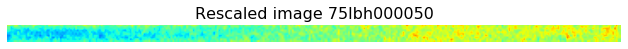

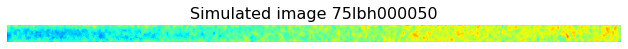

total bubbles: 39814, runtime (min): 27.7, error (%): 3.95
--------------------------------------------------------------



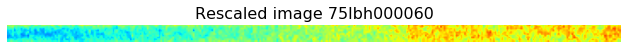

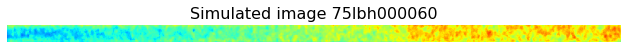

total bubbles: 39605, runtime (min): 33.4, error (%): 3.89
--------------------------------------------------------------



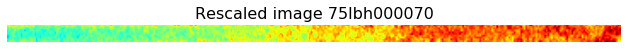

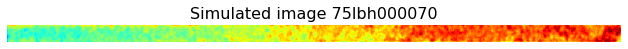

total bubbles: 39828, runtime (min): 39.2, error (%): 3.9
--------------------------------------------------------------



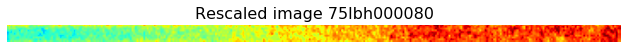

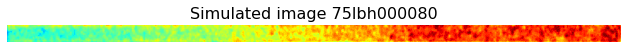

total bubbles: 39162, runtime (min): 45.0, error (%): 3.89
--------------------------------------------------------------



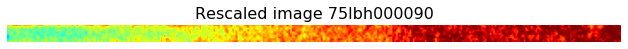

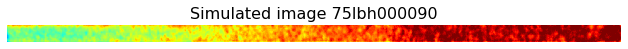

total bubbles: 39445, runtime (min): 50.8, error (%): 3.89
--------------------------------------------------------------



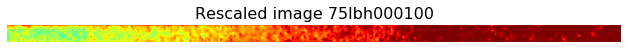

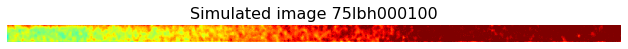

total bubbles: 36633, runtime (min): 56.4, error (%): 3.9
--------------------------------------------------------------



In [6]:
starttime = time()

sim = {}  # create empty dictionary to hold all simulation results

# set parameters for monte carlo simulation
max_bubbles = 1000000  # max number of bubbles to add to simulation
#tot_trials = 3  # total trials to run for each image

#labels=[labels[-1]]
for L in labels:  # loop over each image

    # get target image, rescale so we can work with more pixels, and plot it
    img = d[L]['void_frac_img']
    img = scale_image(img, scaling_factor=int(0.1*channel['w']/len(img[0])))
    plot_channel_image(img, title='Rescaled image '+L, vmin=0, vmax=1)

    #for trial_i in range(tot_trials):

    # simulate empty channel to populate with simulated bubbles
    sim[L] = {'img': np.zeros(img.shape), 'cent': [], 'rad': []}
    simg = sim[L]['img']

    # get limits of pixel coordinates
    xmax, ymax = len(simg[0])-1, len(simg)-1

    # generate array of random bubble centers and radii for seeding simulation
    cent_list = np.zeros((max_bubbles, 2)).astype(int)
    cent_list[:, 0] = np.random.randint(0, len(simg[0]), size=(max_bubbles))
    cent_list[:, 1] = np.random.randint(0, len(simg), size=(max_bubbles))
    rad_list = np.random.randint(
        bubble['min_rad'], bubble['max_rad'], size=(max_bubbles))

    # loop over bubbles and populate simulation
    for b in range(max_bubbles):

        # get random bubble radius and center and scale by channel depth
        rad = rad_list[b]
        cent = cent_list[b]
        bub_profile = get_bubble_profile(rad=rad) / channel['d']

        # get slice indices of image which will be populated by bubble
        x1, x2 = cent[0]-rad, cent[0]+rad+1
        y1, y2 = cent[1]-rad, cent[1]+rad+1
        # trim bubble and image indices if bubble extends outside image range
        if x1 < 0:
            bub_profile = bub_profile[:, -x1:]
            x1 = 0
        if x2 > xmax:
            bub_profile = bub_profile[:, :-(x2-xmax)]
            x2 = xmax
        if y1 < 0:
            bub_profile = bub_profile[-y1:]
            y1 = 0
        if y2 > ymax:
            bub_profile = bub_profile[:-(y2-ymax)]
            y2 = ymax
        
        # add new bubble profile to existing simulation if it will fit
        # first check if radius will fit at that specific center
        current_val = simg[cent[1], cent[0]]
        if current_val + 2*rad/channel['d'] <= img[cent[1], cent[0]]:
        # then check if the whole bubble will fit
            new_profile = np.zeros(simg.shape)
            new_profile[y1:y2, x1:x2] += bub_profile 

            # if entire bubble fits, save its stats and add it to model
            if np.all(simg + new_profile <= 1.05*img):
                simg[y1:y2, x1:x2] += bub_profile 
                sim[L]['cent'].append(cent)
                sim[L]['rad'].append(rad)

    #print('trial {}/{}:'.format(trial_i+1, tot_trials))
    tot_err = np.mean(np.abs(img - simg)/img)*100
    sim[L]['tot_err_percent'] = tot_err
    plot_channel_image(sim[L]['img'], title='Simulated image '+L, vmin=0, vmax=1)
    print('total bubbles: {}, runtime (min): {}, error (%): {}'.format(
        len(sim[L]['rad']),
        round((time() - starttime)/60,1),
        round(tot_err, 2)))
    print('--------------------------------------------------------------\n')

    '''
    # save model to file and download the file to local machine
    serialized_sim = json.dumps(sim, cls=NumpyEncoder)
    with open('/content/channel_models.json', 'w') as dict_to_save:
        json.dump(serialized_sim, dict_to_save)
    files.download('/content/channel_models.json') 
    '''
    # save model to google drive
    #with open('/content/gdrive/My Drive/file.txt', 'w') as f:
    #f.write('content')

    # load dictionary from json file
    #with open('data.json', 'r') as fp:
    #data = json.load(fp)

In [7]:
'''
starttime = time()

sim = {}  # create empty dictionary to hold all simulation results

# set parameters for monte carlo simulation
max_bubbles = 300000  # max number of bubbles to add to simulation
seed_bubbles = 300000  # number of random bubbles to seed the simulation with
#tot_trials = 3  # total trials to run for each image

labels=[labels[-1]]
for L in labels:  # loop over each image

    # get target image, rescale so we can work with more pixels, and plot it
    img = d[L]['void_frac_img']
    img = scale_image(img, scaling_factor=int(0.1*channel['w']/len(img[0])))
    plot_channel_image(img, title='Rescaled image '+L, vmin=0, vmax=1)


    #for trial_i in range(tot_trials):

    # simulate empty channel to populate with simulated bubbles
    sim[L] = {'img': np.zeros(img.shape), 'cent': [], 'rad': []}
    simg = sim[L]['img']

    # get limits of pixel coordinates
    xmax, ymax = len(simg[0])-1, len(simg)-1

    # generate array of random bubble centers and radii for seeding simulation
    cent_list = np.zeros((seed_bubbles, 2)).astype(int)
    cent_list[:, 0] = np.random.randint(0, len(simg[0]), size=(seed_bubbles))
    cent_list[:, 1] = np.random.randint(0, len(simg), size=(seed_bubbles))
    rad_list = np.random.randint(bubble['min_rad'],
                                bubble['max_rad'],
                                size=(max_bubbles))

    # loop over bubbles and populate simulation
    for b in range(max_bubbles):

        # get random bubble radius and scale by channel depth
        rad = rad_list[b]
        bub_profile = get_bubble_profile(rad=rad) / channel['d']


        # after using the random seed bubbles, search for the largest
        # residual between simulation and target image, and use that location
        # as the center of the next bubble
        if b < seed_bubbles:  # use random seed bubbles
            cent = cent_list[b]
        else:  # use bubble centers based on the largest residual
            residual = np.subtract(img, simg)
            cent = tuple(reversed(np.unravel_index(residual.argmax(), img.shape)))

        # get slice indices of image which will be populated by bubble
        x1, x2 = cent[0]-rad, cent[0]+rad+1
        y1, y2 = cent[1]-rad, cent[1]+rad+1
        # trim bubble and image indices if bubble extends outside image range
        if x1 < 0:
            bub_profile = bub_profile[:, -x1:]
            x1 = 0
        if x2 > xmax:
            bub_profile = bub_profile[:, :-(x2-xmax)]
            x2 = xmax
        if y1 < 0:
            bub_profile = bub_profile[-y1:]
            y1 = 0
        if y2 > ymax:
            bub_profile = bub_profile[:-(y2-ymax)]
            y2 = ymax
        
        # add new bubble profile to existing simulation if it will fit
        # first check if radius will fit at that specific center
        current_val = simg[cent[1], cent[0]]
        if current_val + 2*rad/channel['d'] <= img[cent[1], cent[0]]:
        # then check if the whole bubble will fit
            new_profile = np.zeros(simg.shape)
            new_profile[y1:y2, x1:x2] += bub_profile 

            # if entire bubble fits, save its stats and add it to model
            if np.all(simg + new_profile <= 1.05*img):
                simg[y1:y2, x1:x2] += bub_profile 
                sim[L]['cent'].append(cent)
                sim[L]['rad'].append(rad)


    #print('trial {}/{}:'.format(trial_i+1, tot_trials))
    tot_err = np.mean(np.abs(img - simg)/img)*100
    sim[L]['tot_err_percent'] = tot_err
    plot_channel_image(sim[L]['img'], title='Simulated image '+L, vmin=0, vmax=1)
    print('total bubbles: {}'.format(len(sim[L]['rad'])))
    print('runtime (min): {}'.format(round((time() - starttime)/60,1)))
    print('model error: {}%'.format(np.round(tot_err, 2)))
    print('---------------------------------------------------------\n')



    # save model to file and download the file to local machine
    serialized_sim = json.dumps(sim, cls=NumpyEncoder)
    with open('/content/channel_models.json', 'w') as dict_to_save:
        json.dump(serialized_sim, dict_to_save)
    files.download('/content/channel_models.json') 

    # save model to google drive
    #with open('/content/gdrive/My Drive/file.txt', 'w') as f:
    #f.write('content')


    # load dictiionary from json file
    #with open('data.json', 'r') as fp:
    #data = json.load(fp)
'''

"\nstarttime = time()\n\nsim = {}  # create empty dictionary to hold all simulation results\n\n# set parameters for monte carlo simulation\nmax_bubbles = 300000  # max number of bubbles to add to simulation\nseed_bubbles = 300000  # number of random bubbles to seed the simulation with\n#tot_trials = 3  # total trials to run for each image\n\nlabels=[labels[-1]]\nfor L in labels:  # loop over each image\n\n    # get target image, rescale so we can work with more pixels, and plot it\n    img = d[L]['void_frac_img']\n    img = scale_image(img, scaling_factor=int(0.1*channel['w']/len(img[0])))\n    plot_channel_image(img, title='Rescaled image '+L, vmin=0, vmax=1)\n\n\n    #for trial_i in range(tot_trials):\n\n    # simulate empty channel to populate with simulated bubbles\n    sim[L] = {'img': np.zeros(img.shape), 'cent': [], 'rad': []}\n    simg = sim[L]['img']\n\n    # get limits of pixel coordinates\n    xmax, ymax = len(simg[0])-1, len(simg)-1\n\n    # generate array of random bubble 

In [8]:
'''
a = np.random.random(9).reshape((3,3))
b = np.random.random(9).reshape((3,3))
print(a)
print(b)
c = a - b
print(c)
print(np.unravel_index(c.argmax(), c.shape))
'''

'\na = np.random.random(9).reshape((3,3))\nb = np.random.random(9).reshape((3,3))\nprint(a)\nprint(b)\nc = a - b\nprint(c)\nprint(np.unravel_index(c.argmax(), c.shape))\n'

In [9]:
tuple(reversed((5,6,7)))

(7, 6, 5)

In [10]:
''''
# loop over every bubble and reconstruct the image
reconstructed_img = np.zeros_like(sim['img'])
for i in range(len(sim['rad'])):
    cent = sim['cent'][i]
    bub_profile = get_bubble_profile(rad=sim['rad'][i]) / channel['d']
    reconstructed_img = add_bubble_to_grid(
        reconstructed_img, bub_profile, rad=sim['rad'][i], cent=sim['cent'][i])
plot_channel_image(reconstructed_img, vmin=0, vmax=1)
'''

"'\n# loop over every bubble and reconstruct the image\nreconstructed_img = np.zeros_like(sim['img'])\nfor i in range(len(sim['rad'])):\n    cent = sim['cent'][i]\n    bub_profile = get_bubble_profile(rad=sim['rad'][i]) / channel['d']\n    reconstructed_img = add_bubble_to_grid(\n        reconstructed_img, bub_profile, rad=sim['rad'][i], cent=sim['cent'][i])\nplot_channel_image(reconstructed_img, vmin=0, vmax=1)\n"

## Examine statistics of bubble distribution

In [0]:
def get_stats(arr):
    """Return stats of an array in dictioary form."""
    d = {'min': np.min(arr), 'max': np.max(arr),
         'mean': np.mean(arr), 'median': np.median(arr), 'std': np.std(arr)}
    return d


def simulation_report(sim):
    """Create histograms which summarize statistics of the simulation."""
    # plot histogram of bubble radii
    d = get_stats(sim['rad'])
    print('Radius statistics:')
    [print('{}: {}'.format(key, val)) for key, val in d.items()]
    plt.hist(sim['rad'], bins=60)
    plot_setup(title='Distribution of bubble radii',
            labels=['Radius (μm)', 'Frequency'], size=(5, 3))
    plt.show()

    # plot histogram of bubble center y-values
    yvals = [pair[1] for pair in sim['cent']]
    plot_setup(title='Bubble positions perpendicular to channel',
            labels=['Position (μm)', 'Frequency'], size=(5, 3))
    plt.hist(yvals, bins=60)
    plt.show()
    # plot histogram of bubble center x-values
    xvals = [pair[0] for pair in sim['cent']]
    plot_setup(title='Bubble positions parallel to channel',
            labels=['Position (μm)', 'Frequency'], size=(5, 3))
    plt.hist(xvals, bins=60)
    plt.show()

#simulation_report(sim)

### Test some configurations for a single pixel

In [0]:
# set target value based on pixel intensity scaled by depth of channel




## Old / unused methods

### Calculate possible decrete bubble configurations

In [12]:
'''
def possible_bubble_frequencies(bubble, channel):
    """Generate possible bubble frequencies based on their size constraints,
    number of unique sizes."""
    # max frequency of any possible bubble size
    max_freq = list(range(1+math.ceil(channel['h']/bubble['min'])))
    num_of_sizes = bubble['unique_sizes']
    # get all possible frequencies of each bubble size
    arr = np.array(list(itertools.product(max_freq, repeat=num_of_sizes)))
    print('Searching {} potential configurations...'.format(len(arr)))
    # select only the configurations which are inside physical limits
    total_diameter = np.sum(arr*bubble['diameters'], axis=1)
    idx = np.where(total_diameter <= channel['h'])
    arr = arr[idx]
    print('Found {} relevant configurations.'.format(len(arr)))
    return arr


def plot_possible_bubble_stacks(bubble):
    """Use bar graph to display possible configurations of bubble stacks
    inside the channel based on their possible diameters and frequencies."""
    # the x locations for the bars
    ind = np.arange(len(bubble['frequencies']))  
    # loop over each bubble diameter, keeping list of plots and tops of bars
    p = []
    cumulative_tops = np.zeros_like(ind)
    for d in range(len(bubble['diameters'])):
        # set top of bars
        y_top = bubble['diameters'][d] * bubble['frequencies'][:,d]
        # set bottom of bars
        bottom = 0 if d == 0 else cumulative_tops
        p.append(plt.bar(ind, y_top,
                         width=0.3, lw=1,
                         edgecolor='k',
                         bottom=bottom))
        # save previous top of bars to use as next bottom
        cumulative_tops += y_top
    plot_setup(title='Possible bubble configurations by diameter',
            labels=['Diameter frequencies', 'Total cross section'])
    plt.xticks(ind, [str(f) for f in bubble['frequencies']], rotation=90)
    #plt.yticks(np.arange(0, 81, 10))
    labels=bubble['diameters'].astype(str)
    plt.legend([p[i][0] for i in range(len(bubble['diameters']))],
            labels, fontsize=14)
    fig = plt.gcf()
    fig.set_size_inches((9, 5))
    plt.show()
'''

'\ndef possible_bubble_frequencies(bubble, channel):\n    """Generate possible bubble frequencies based on their size constraints,\n    number of unique sizes."""\n    # max frequency of any possible bubble size\n    max_freq = list(range(1+math.ceil(channel[\'h\']/bubble[\'min\'])))\n    num_of_sizes = bubble[\'unique_sizes\']\n    # get all possible frequencies of each bubble size\n    arr = np.array(list(itertools.product(max_freq, repeat=num_of_sizes)))\n    print(\'Searching {} potential configurations...\'.format(len(arr)))\n    # select only the configurations which are inside physical limits\n    total_diameter = np.sum(arr*bubble[\'diameters\'], axis=1)\n    idx = np.where(total_diameter <= channel[\'h\'])\n    arr = arr[idx]\n    print(\'Found {} relevant configurations.\'.format(len(arr)))\n    return arr\n\n\ndef plot_possible_bubble_stacks(bubble):\n    """Use bar graph to display possible configurations of bubble stacks\n    inside the channel based on their possible diam

In [13]:
'''
# define channel dimensions (width, height, depth) in micrometers
channel = {'w': 22000, 'h': 250, 'd': 750}

# define bubble diameter limits and minimum buffer distance between bubbles
bubble = {'max': 250, 'min': 50, 'buffer': 5, 'unique_sizes': 6}
bubble['diameters'] = np.linspace(bubble['min'],
                                  bubble['max'],
                                  bubble['unique_sizes']).astype(int)

# find all possible sets of bubble frequencies which can be possible
bubble['frequencies'] = possible_bubble_frequencies(bubble, channel)


# plot the possible bubble configuration stacks that can fit in the channel
if len(bubble['frequencies']) > 0:
    plot_possible_bubble_stacks(bubble)
else:
    print('No pysically-possible configurations.')
'''

"\n# define channel dimensions (width, height, depth) in micrometers\nchannel = {'w': 22000, 'h': 250, 'd': 750}\n\n# define bubble diameter limits and minimum buffer distance between bubbles\nbubble = {'max': 250, 'min': 50, 'buffer': 5, 'unique_sizes': 6}\nbubble['diameters'] = np.linspace(bubble['min'],\n                                  bubble['max'],\n                                  bubble['unique_sizes']).astype(int)\n\n# find all possible sets of bubble frequencies which can be possible\nbubble['frequencies'] = possible_bubble_frequencies(bubble, channel)\n\n\n# plot the possible bubble configuration stacks that can fit in the channel\nif len(bubble['frequencies']) > 0:\n    plot_possible_bubble_stacks(bubble)\nelse:\n    print('No pysically-possible configurations.')\n"